In [2]:
import gym
from gym import spaces
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
# Defining the Stock Trading Environment.
"""DON'T MAKE ANY CHANGES TO THE ENVIRONMENT."""


class StockTradingEnvironment(gym.Env):
    """This class implements the Stock Trading environment."""

    def __init__(self, file_path, train=True, number_of_days_to_consider=10):
        """This method initializes the environment.

        :param file_path: - Path of the CSV file containing the historical stock data.
        :param train: - Boolean indicating whether the goal is to train or test the performance of the agent.
        :param number_of_days_to_consider = Integer representing the number of days the for which the agent
                considers the trend in stock price to make a decision."""

        self.file_path = file_path
        self.stock_data = pd.read_csv(self.file_path)
        self.train = train

        # Splitting the data into train and test datasets.
        self.training_stock_data = self.stock_data.iloc[:int(0.8 * len(self.stock_data))]
        self.testing_stock_data = self.stock_data.iloc[int(0.8 * len(self.stock_data)):].reset_index()

        self.observation_space = spaces.Discrete(4)
        self.action_space = spaces.Discrete(3)

        self.investment_capital = 100000  # This defines the investment capital that the agent starts with.
        self.number_of_shares = 0  # This defines number of shares currently held by the agent.
        self.stock_value = 0  # This defines the value of the stock currently held by the agent.
        self.book_value = 0  # This defines the total value for which the agent bought the shares.
        # This defines the agent's total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # List to store the total account value over training or evaluation.
        self.total_account_value_list = []
        # This defines the number of days for which the agent considers the data before taking an action.
        self.number_of_days_to_consider = number_of_days_to_consider
        # The maximum timesteps the agent will take before the episode ends.
        if self.train:
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider
        else:
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider
        # Initializing the number of steps taken to 0.
        self.timestep = 0
        self.reset()

    def reset(self):
        """This method resets the environment and returns the observation.

        :returns observation: - Integer in the range of 0 to 3 representing the four possible observations that the
                                agent can receive. The observation depends upon whether the price increased on average
                                in the number of days the agent considers, and whether the agent already has the stock
                                or not.

                 info: - info: - A dictionary that can be used to provide additional implementation information."""

        self.investment_capital = 100000  # This defines the investment capital that the agent starts with.
        self.number_of_shares = 0  # This defines number of shares currently held by the agent.
        self.stock_value = 0  # This defines the value of the stock currently held by the agent.
        self.book_value = 0  # This defines the total value for which the agent bought the shares.
        # This defines the agent's total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # List to store the total account value over training or evaluation.
        self.total_account_value_list = []
        # Initializing the number of steps taken to 0.
        self.timestep = 0

        # Getting the observation vector.
        if self.train:
            # If the task is to train the agent the maximum timesteps will be equal to the number of days considered
            # subtracted from the  length of the training stock data.
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.training_stock_data['Close'][self.timestep + 1 + i] \
                        - self.training_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            stock_held = False

            # Observation vector that will be passed to the agent.
            observation = [price_increase, stock_held]

        else:
            # If the task is to evaluate the trained agent's performance the maximum timesteps will be equal to the
            # number of days considered subtracted from the  length of the testing stock data.
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.testing_stock_data['Close'][self.timestep + 1 + i] \
                        - self.testing_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            stock_held = False

            # Observation vector.
            observation = [price_increase, stock_held]

        if np.array_equal(observation, [True, False]):
            observation = 0
        if np.array_equal(observation, [True, True]):
            observation = 1
        if np.array_equal(observation, [False, False]):
            observation = 2
        if np.array_equal(observation, [False, True]):
            observation = 3

        info = None

        return observation, info

    def step(self, action):
        """This method implements what happens when the agent takes the action to Buy/Sell/Hold.

        :param action: - Integer in the range 0 to 2 inclusive.

        :returns observation: - Integer in the range of 0 to 3 representing the four possible observations that the
                                agent can receive. The observation depends upon whether the price increased on average
                                in the number of days the agent considers, and whether the agent already has the stock
                                or not.
                 reward: - Integer/Float value that's used to measure the performance of the agent.
                 terminated: - Boolean describing whether the episode has terminated.
                 truncated: - Boolean describing whether a truncation condition outside the scope of the MDP is satisfied.
                 info: - A dictionary that can be used to provide additional implementation information."""

        # We give the agent a penalty for taking actions such as buying a stock when the agent doesn't have the
        # investment capital and selling a stock when the agent doesn't have any shares.
        penalty = 0

        if self.train:
            if action == 0:  # Buy
                if self.number_of_shares > 0:
                    penalty = -10
                # Determining the number of shares the agent can buy.
                number_of_shares_to_buy = math.floor(self.investment_capital / self.training_stock_data[
                    'Open'][self.timestep + self.number_of_days_to_consider])
                # Adding to the number of shares the agent has.
                self.number_of_shares += number_of_shares_to_buy

                # Computing the stock value, book value, investment capital and reward.
                if number_of_shares_to_buy > 0:
                    self.stock_value +=\
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.book_value += \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider]\
                        * number_of_shares_to_buy
                    self.investment_capital -= \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy

                    reward = 1 + penalty

                else:
                    # Computing the stock value and reward.
                    self.stock_value = \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * self.number_of_shares
                    reward = -10

            if action == 1:  # Sell
                # Computing the investment capital, sell value and reward.
                self.investment_capital += \
                    self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                    * self.number_of_shares
                sell_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                             * self.number_of_shares

                if self.book_value > 0:
                    reward = (sell_value - self.book_value) / self.book_value * 100
                else:
                    reward = -10

                self.number_of_shares = 0
                self.stock_value = 0
                self.book_value = 0

            if action == 2:  # Hold
                # Computing the stock value and reward.
                self.stock_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                                   * self.number_of_shares

                if self.book_value > 0:
                    reward = (self.stock_value - self.book_value) / self.book_value * 100
                else:
                    reward = -1

        else:
            if action == 0:  # Buy
                if self.number_of_shares > 0:
                    penalty = -10
                # Determining the number of shares the agent can buy.
                number_of_shares_to_buy = math.floor(self.investment_capital / self.testing_stock_data[
                    'Open'][self.timestep + self.number_of_days_to_consider])
                # Adding to the number of shares the agent has.
                self.number_of_shares += number_of_shares_to_buy

                # Computing the stock value, book value, investment capital and reward.
                if number_of_shares_to_buy > 0:
                    self.stock_value += \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.book_value += \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.investment_capital -= \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy

                    reward = 1 + penalty

                else:
                    # Computing the stock value and reward.
                    self.stock_value = self.training_stock_data['Open'][
                                           self.timestep + self.number_of_days_to_consider] * self.number_of_shares
                    reward = -10

            if action == 1:  # Sell
                # Computing the investment capital, sell value and reward.
                self.investment_capital += \
                    self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                    * self.number_of_shares
                sell_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                             * self.number_of_shares

                if self.book_value > 0:
                    reward = (sell_value - self.book_value) / self.book_value * 100
                else:
                    reward = -10

                self.number_of_shares = 0
                self.stock_value = 0
                self.book_value = 0

            if action == 2:  # Hold
                # Computing the stock value and reward.
                self.stock_value = self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                                   * self.number_of_shares

                if self.book_value > 0:
                    reward = (self.stock_value - self.book_value) / self.book_value * 100
                else:
                    reward = -1

        # Determining if the agent currently has shares of the stock or not.
        if self.number_of_shares > 0:
            stock_held = True
        else:
            stock_held = False

        # Getting the observation vector.
        if self.train:
            # If the task is to train the agent the maximum timesteps will be equal to the number of days considered
            # subtracted from the  length of the training stock data.
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.training_stock_data['Close'][self.timestep + 1 + i] \
                        - self.training_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            # Observation vector.
            observation = [price_increase, stock_held]

        else:
            # If the task is to evaluate the trained agent's performance the maximum timesteps will be equal to the
            # number of days considered subtracted from the  length of the testing stock data.
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.testing_stock_data['Close'][self.timestep + 1 + i] \
                        - self.testing_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            # Observation vector.
            observation = [price_increase, stock_held]

        self.timestep += 1  # Increasing the number of steps taken by the agent by 1.

        if np.array_equal(observation, [True, False]):
            observation = 0
        if np.array_equal(observation, [True, True]):
            observation = 1
        if np.array_equal(observation, [False, False]):
            observation = 2
        if np.array_equal(observation, [False, True]):
            observation = 3

        # Computing the total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # Appending the total account value of the list to plot the graph.
        self.total_account_value_list.append(self.total_account_value)

        # The episode terminates when the maximum timesteps have been reached.
        terminated = True if (self.timestep >= self.max_timesteps) \
            else False
        truncated = False
        info = {}

        return observation, reward, terminated, truncated, info

    def render(self, mode='human'):
        """This method renders the agent's total account value over time.

        :param mode: 'human' renders to the current display or terminal and returns nothing."""

        plt.figure(figsize=(15, 10))
        plt.plot(self.total_account_value_list, color='lightseagreen', linewidth=7)
        plt.xlabel('Days', fontsize=32)
        plt.ylabel('Total Account Value', fontsize=32)
        plt.title('Total Account Value over Time', fontsize=38)
        plt.grid()
        plt.show()

In [4]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from gym import spaces


class DuelingStockTradingNet(nn.Module):
    def __init__(self):
        super(DuelingStockTradingNet, self).__init__()
        self.fc1 = nn.Linear(4, 64)
        self.fc1.weight.data.normal_(0, 0.1)


        self.value_stream = nn.Linear(64, 1)
        self.value_stream.weight.data.normal_(0, 0.1)
        self.advantage_stream = nn.Linear(64, 3)
        self.advantage_stream.weight.data.normal_(0, 0.1)

    def forward(self, x):
        x = F.relu(self.fc1(x))

        value = self.value_stream(x)
        advantages = self.advantage_stream(x)


        q_values = value + (advantages - advantages.mean(dim=1, keepdim=True))

        return q_values

In [5]:
class StockTradingAgent:
    def __init__(self, environment, batch_size=50, replay_capacity=1500, exploration_rate=1.0, exploration_decay=0.9995, discount_factor=0.9):
        self.environment = environment
        self.state_dimension = environment.observation_space.n
        self.action_dimension = environment.action_space.n
        self.replay_buffer = np.zeros((replay_capacity, 2 * self.state_dimension + 3))
        self.policy_net = DuelingStockTradingNet()
        self.target_net = DuelingStockTradingNet()
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.policy_net.parameters())
        self.batch_size = batch_size
        self.replay_capacity = replay_capacity
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.discount_factor = discount_factor
        self.learning_step_counter = 0

        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

    def select_action(self, state):
        one_hot_state = np.zeros(self.state_dimension)
        one_hot_state[state] = 1
        one_hot_state = torch.FloatTensor(one_hot_state).unsqueeze(0)
        if np.random.rand() > self.exploration_rate:
            with torch.no_grad():
                action_values = self.policy_net(one_hot_state)
                action = action_values.max(1)[1].view(1, 1)
        else:
            action = torch.tensor([[np.random.randint(0, self.action_dimension)]], dtype=torch.long)
        return action

    def store_transition(self, state, action, reward, next_state, done):
        one_hot_state = np.zeros(self.state_dimension)
        one_hot_state[state] = 1
        one_hot_next_state = np.zeros(self.state_dimension)
        one_hot_next_state[next_state] = 1
        transition = np.concatenate((one_hot_state, [action, reward], one_hot_next_state, [int(done)]))
        index = self.learning_step_counter % self.replay_capacity
        self.replay_buffer[index, :] = transition
        self.learning_step_counter += 1

    def optimize_model(self):
        if self.learning_step_counter < self.batch_size:
            return
        sample_indices = np.random.choice(min(self.replay_capacity, self.learning_step_counter), self.batch_size)
        batch = self.replay_buffer[sample_indices, :]
        state_batch = torch.FloatTensor(batch[:, :self.state_dimension])
        action_batch = torch.LongTensor(batch[:, self.state_dimension:self.state_dimension+1].astype(int))
        reward_batch = torch.FloatTensor(batch[:, self.state_dimension+1:self.state_dimension+2])
        next_state_batch = torch.FloatTensor(batch[:, self.state_dimension+2:-1])

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_actions = self.policy_net(next_state_batch).max(1)[1].unsqueeze(1)

        next_state_values = self.target_net(next_state_batch).gather(1, next_state_actions).detach()

        expected_state_action_values = (next_state_values * self.discount_factor) + reward_batch

        loss = self.criterion(state_action_values, expected_state_action_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.exploration_rate = max(self.exploration_rate * self.exploration_decay, 0.01)

        if self.learning_step_counter % 100 == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())


Episode: 1, Total Reward: -2145.072753842195, Account Value: 134694.02510899995, Epsilon: 0.16373146555890544
Episode: 2, Total Reward: -543.6153306517573, Account Value: 118925.90646300011, Epsilon: 0.022835098131175
Episode: 3, Total Reward: 210.19254937253723, Account Value: 111313.05463200004, Epsilon: 0.01
Episode: 4, Total Reward: 186.89008097314007, Account Value: 78708.37574099979, Epsilon: 0.01
Episode: 5, Total Reward: 218.426549267866, Account Value: 138931.55471799997, Epsilon: 0.01
Episode: 6, Total Reward: 149.58328163907106, Account Value: 94247.92455199982, Epsilon: 0.01
Episode: 7, Total Reward: 131.0815625652223, Account Value: 57649.01271199982, Epsilon: 0.01
Episode: 8, Total Reward: 171.915269865477, Account Value: 84960.07420300001, Epsilon: 0.01
Episode: 9, Total Reward: 185.69027380256927, Account Value: 79562.20084599975, Epsilon: 0.01
Episode: 10, Total Reward: 203.62224255759298, Account Value: 105798.64458799998, Epsilon: 0.01
Episode: 11, Total Reward: 73.0

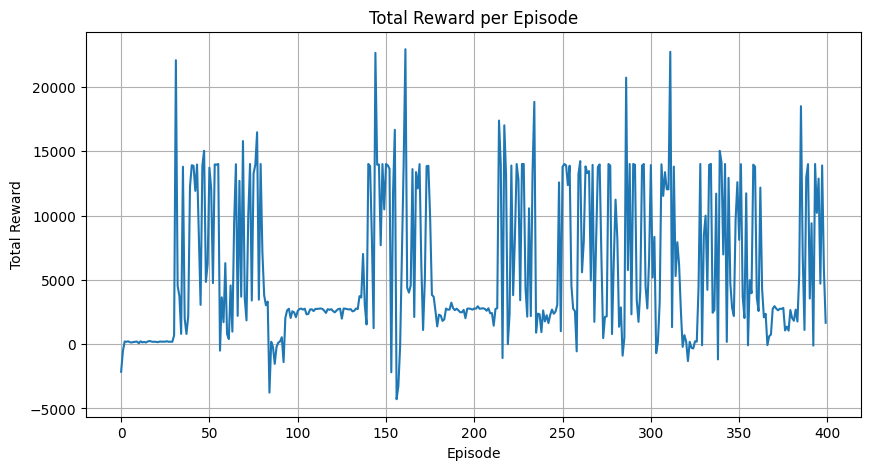

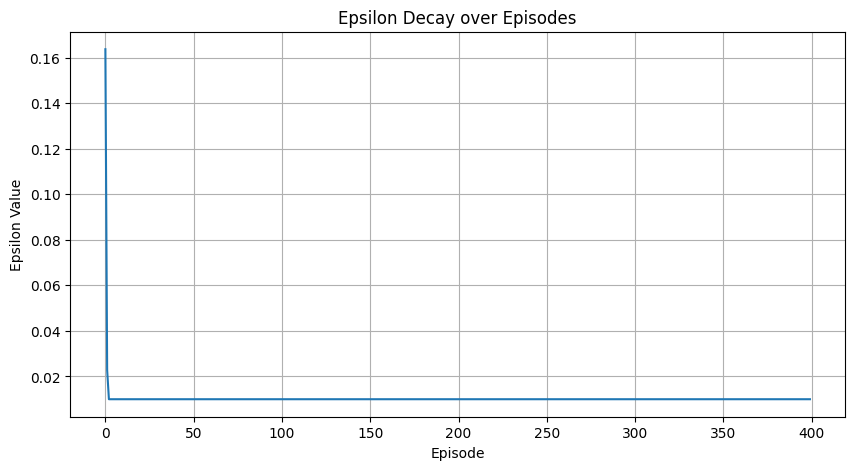

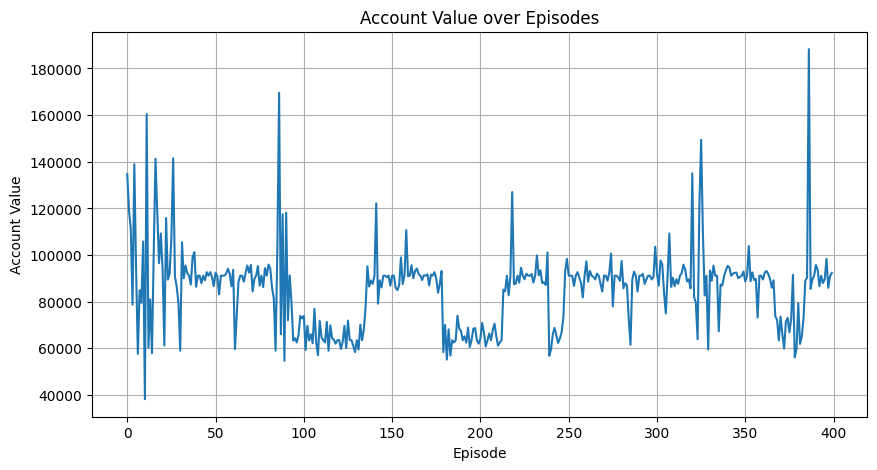

In [7]:
if __name__ == '__main__':
    file_path = './NVDA.csv'
    env = StockTradingEnvironment(file_path=file_path, number_of_days_to_consider=10)
    agent = StockTradingAgent(env, batch_size=32, replay_capacity=500, exploration_rate=1.0, exploration_decay=0.995, discount_factor=0.9)

    num_episodes = 400
    rewards = []
    epsilons = []
    account_values = []

    for episode in range(num_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = agent.select_action(state)
            next_state, reward, done, *_ = env.step(action.item())
            agent.store_transition(state, action.item(), reward, next_state, done)
            state = next_state
            total_reward += reward
            if agent.learning_step_counter > agent.batch_size:
                agent.optimize_model()

        rewards.append(total_reward)
        epsilons.append(agent.exploration_rate)
        account_values.append(env.total_account_value)
        print(f"Episode: {episode + 1}, Total Reward: {total_reward}, Account Value: {env.total_account_value}, Epsilon: {agent.exploration_rate}")

    plt.figure(figsize=(10, 5))
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Total Reward per Episode')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(epsilons)
    plt.xlabel('Episode')
    plt.ylabel('Epsilon Value')
    plt.title('Epsilon Decay over Episodes')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(account_values)
    plt.xlabel('Episode')
    plt.ylabel('Account Value')
    plt.title('Account Value over Episodes')
    plt.grid(True)
    plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


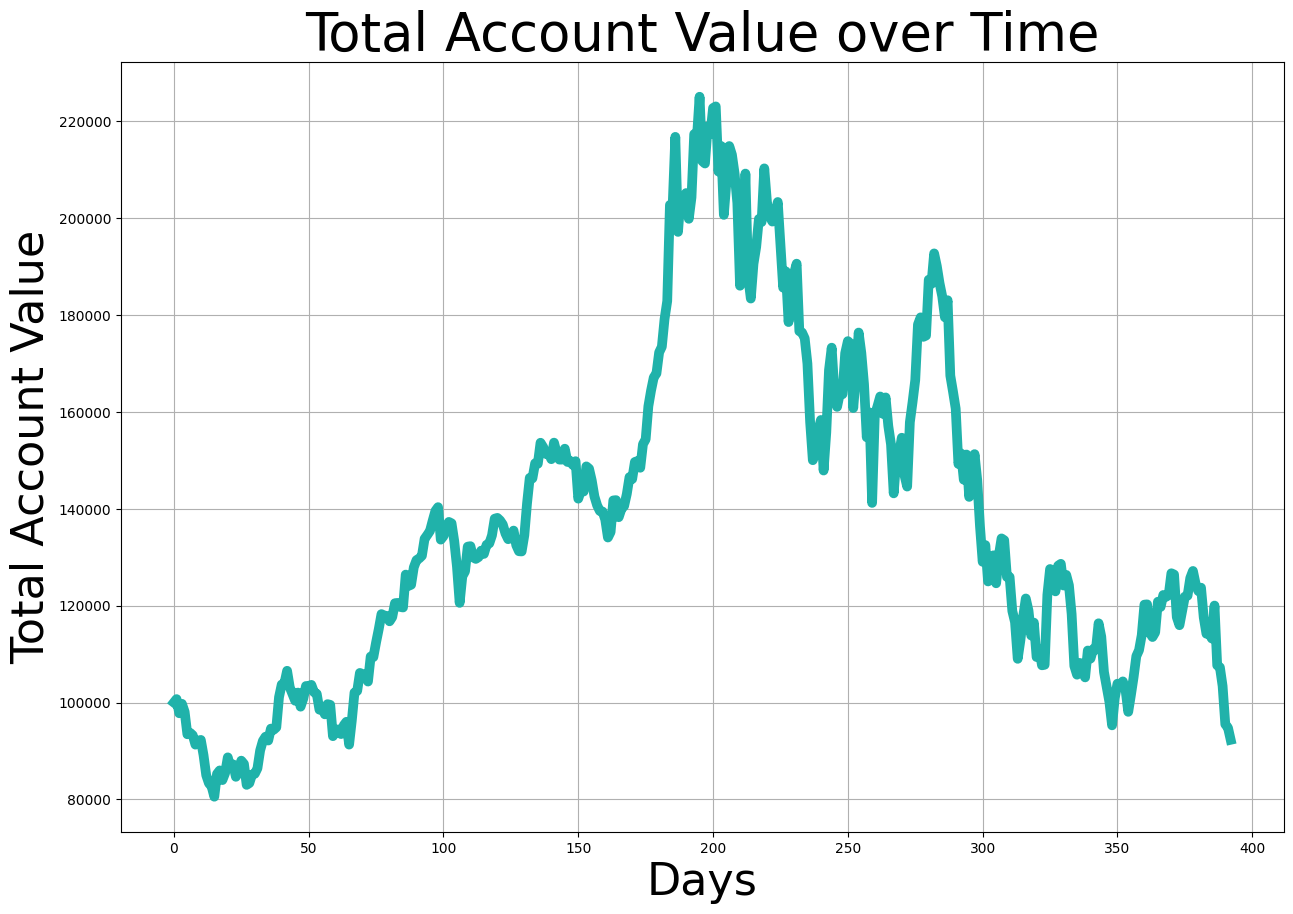

In [8]:
env.render()

Model file not found, testing with uninitialized model.
Action taken: 0
Reward received: 1, New state: 1
Action taken: 0
Reward received: -10, New state: 1
Action taken: 0
Reward received: -10, New state: 3
Action taken: 2
Reward received: -5.464315996960735, New state: 3
Action taken: 2
Reward received: -5.343226165775153, New state: 3
Action taken: 2
Reward received: -6.0773531341348335, New state: 1
Action taken: 0
Reward received: -10, New state: 1
Action taken: 0
Reward received: -10, New state: 3
Action taken: 2
Reward received: -6.554153994015223, New state: 3
Action taken: 2
Reward received: -2.5278225032989377, New state: 1
Action taken: 0
Reward received: -10, New state: 1
Action taken: 0
Reward received: -10, New state: 1
Action taken: 0
Reward received: -10, New state: 1
Action taken: 0
Reward received: -10, New state: 1
Action taken: 0
Reward received: -10, New state: 3
Action taken: 2
Reward received: -12.366611202353331, New state: 3
Action taken: 2
Reward received: -16.

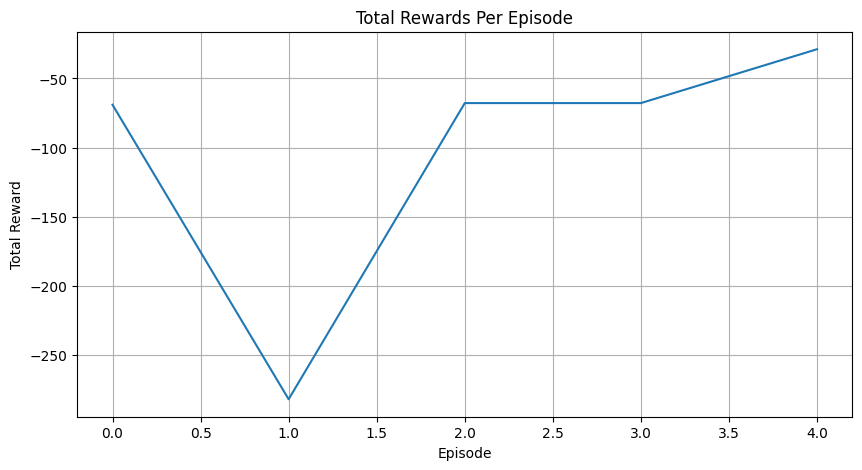

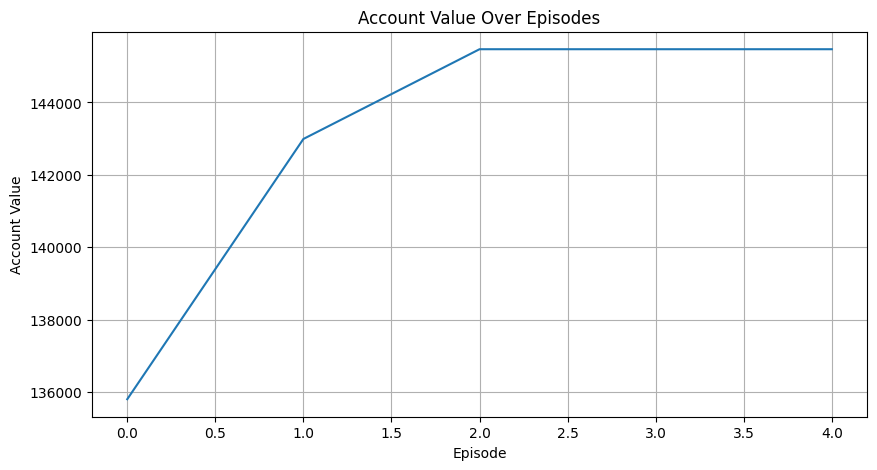

In [16]:
import torch

def test_trained_agent(env, agent, num_episodes=80):
    """Test the trained agent for a given number of episodes and visualize the results."""
    total_rewards = []
    account_values = []


    agent.policy_net.eval()

    for episode in range(num_episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = agent.select_action(state)
            print(f"Action taken: {action.item()}")
            next_state, reward, done, *_ = env.step(action.item())
            print(f"Reward received: {reward}, New state: {next_state}")
            state = next_state
            total_reward += reward

        total_rewards.append(total_reward)
        account_values.append(env.total_account_value)
        print(f"Test Episode: {episode + 1}, Total Reward: {total_reward}, Account Value: {env.total_account_value}")


    plt.figure(figsize=(10, 5))
    plt.plot(total_rewards)
    plt.title('Total Rewards Per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(account_values)
    plt.title('Account Value Over Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Account Value')
    plt.grid(True)
    plt.show()

if __name__ == '__main__':
    file_path = './NVDA.csv'
    env = StockTradingEnvironment(file_path=file_path, number_of_days_to_consider=10, train=False)
    agent = StockTradingAgent(env, batch_size=32, replay_capacity=500, exploration_rate=0.01, exploration_decay=0.995, discount_factor=0.9)


    try:
        agent.policy_net.load_state_dict(torch.load('path_to_saved_model.pth'))
        print("Model loaded successfully.")
    except FileNotFoundError:
        print("Model file not found, testing with uninitialized model.")

    test_trained_agent(env, agent, num_episodes=5)


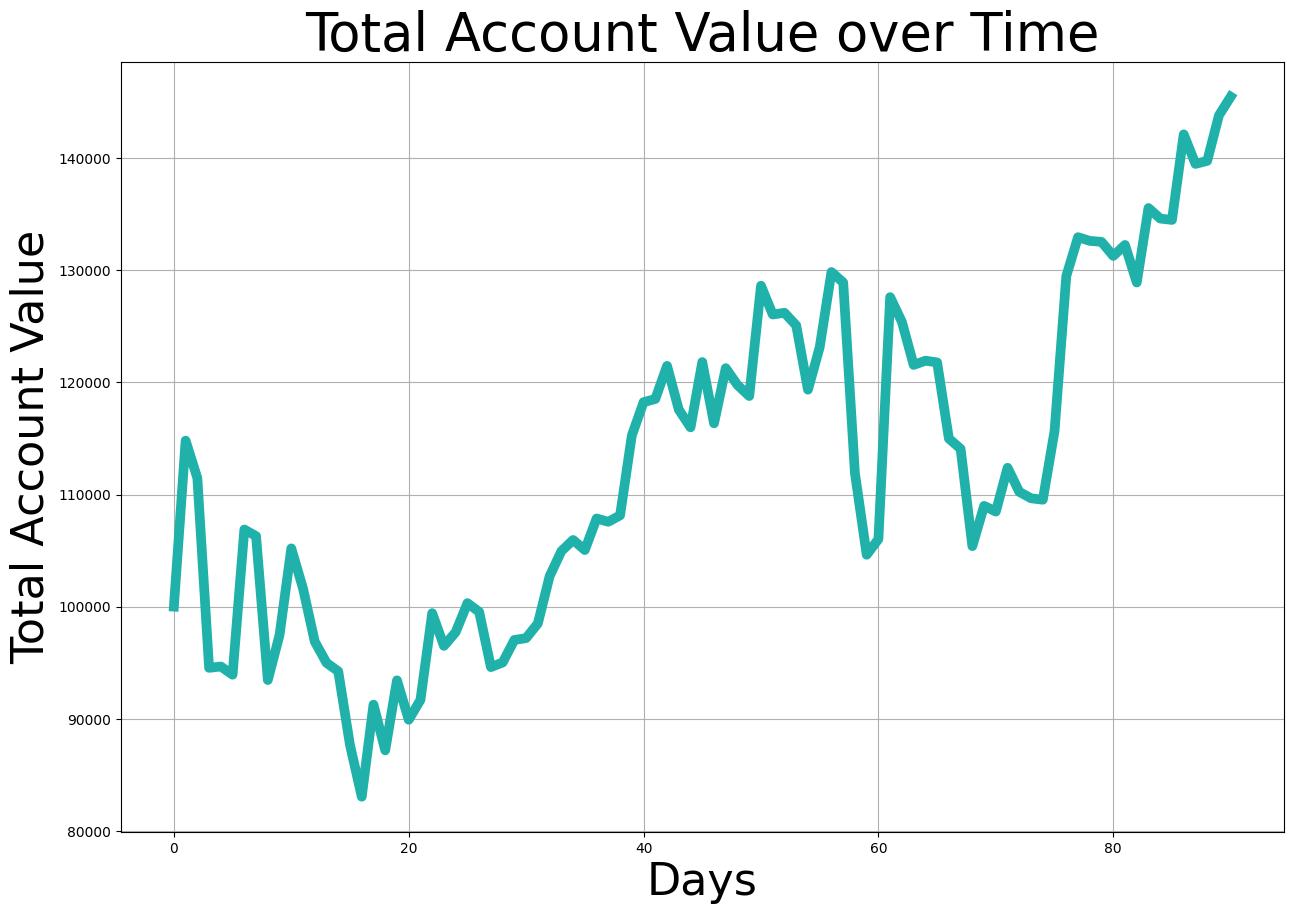

In [17]:
env.render()

In [79]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import Categorical
import random


class Critic(nn.Module):
    def __init__(self, input_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

class Actor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.softmax(self.fc2(x), dim=-1)

def one_hot_encode(state, state_dimension):
    one_hot_state = torch.zeros(state_dimension)
    one_hot_state[state] = 1
    return one_hot_state

def update_targets(target, original, tau=0.005):
    for target_param, param in zip(target.parameters(), original.parameters()):
        target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

In [80]:
def td3_update(actor, actor_target, critic1, critic1_target, critic2, critic2_target,
               actor_optimizer, critic1_optimizer, critic2_optimizer,
               states, actions, rewards, next_states, dones, gamma=0.99, policy_noise=0.2,
               noise_clip=0.5, policy_freq=2, step=0):
    states = torch.FloatTensor(states)
    actions = torch.LongTensor(actions).unsqueeze(1).clamp(0, 0)
    rewards = torch.FloatTensor(rewards).unsqueeze(1)
    next_states = torch.FloatTensor(next_states)
    dones = torch.BoolTensor(dones).unsqueeze(1)

    next_action = actor_target(next_states)
    noise = (torch.randn_like(next_action) * policy_noise).clamp(-noise_clip, noise_clip)
    next_action = (next_action + noise).clamp(0, 1)


    target_Q1 = critic1_target(next_states)
    target_Q2 = critic2_target(next_states)
    target_Q = torch.min(target_Q1, target_Q2) - rewards + (gamma * next_action * (1.0 - dones.float()))


    current_Q1 = critic1(states).gather(1, actions)
    current_Q2 = critic2(states).gather(1, actions)


    critic1_loss = F.mse_loss(current_Q1, target_Q.detach())
    critic2_loss = F.mse_loss(current_Q2, target_Q.detach())


    critic1_optimizer.zero_grad()
    critic2_optimizer.zero_grad()
    critic1_loss.backward()
    critic2_loss.backward()
    critic1_optimizer.step()
    critic2_optimizer.step()


    if step % policy_freq == 0:

        actor_loss = -critic1(states).mean()


        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()


        update_targets(actor_target, actor, tau=0.005)
        update_targets(critic1_target, critic1, tau=0.005)
        update_targets(critic2_target, critic2, tau=0.005)

In [81]:
def train_td3(env, actor, critic1, critic2, actor_target, critic1_target, critic2_target,
              actor_optimizer, critic1_optimizer, critic2_optimizer, num_episodes=1000):
    for episode in range(num_episodes):
        state = env.reset()
        state = one_hot_encode(state, env.observation_space.n)
        done = False
        total_reward = 0
        step = 0
        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            action = actor(state_tensor).multinomial(1).item()

            next_state, reward, terminated, truncated, _ = env.step(action)
            next_state = one_hot_encode(next_state, env.observation_space.n)
            done = terminated or truncated
            td3_update(actor, actor_target, critic1, critic1_target, critic2, critic2_target,
                       actor_optimizer, critic1_optimizer, critic2_optimizer,
                       [state.numpy()], [action], [reward], [next_state.numpy()], [done],
                       step=step)
            state = next_state
            total_reward += reward
            step += 1
        print(f'Episode {episode}: Total Reward: {total_reward}')

if __name__ == '__main__':
    env = StockTradingEnvironment(file_path='./NVDA.csv', number_of_days_to_consider=10)
    actor = Actor(env.observation_space.n, env.action_space.n)
    critic1 = Critic(env.observation_space.n)
    critic2 = Critic(env.observation_space.n)
    actor_target = Actor(env.observation_space.n, env.action_space.n)
    critic1_target = Critic(env.observation_space.n)
    critic2_target = Critic(env.observation_space.n)
    actor_target.load_state_dict(actor.state_dict())
    critic1_target.load_state_dict(critic1.state_dict())
    critic2_target.load_state_dict(critic2.state_dict())

    actor_optimizer = optim.Adam(actor.parameters(), lr=1e-3)
    critic1_optimizer = optim.Adam(critic1.parameters(), lr=1e-3)
    critic2_optimizer = optim.Adam(critic2.parameters(), lr=1e-3)

    train_td3(env, actor, critic1, critic2, actor_target, critic1_target, critic2_target,
              actor_optimizer, critic1_optimizer, critic2_optimizer)

<ipython-input-80-5424a3341cd6>:25: UserWarning: Using a target size (torch.Size([1, 3])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic1_loss = F.mse_loss(current_Q1, target_Q.detach())
<ipython-input-80-5424a3341cd6>:26: UserWarning: Using a target size (torch.Size([1, 3])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic2_loss = F.mse_loss(current_Q2, target_Q.detach())


Episode 0: Total Reward: -1255.4730057813044
Episode 1: Total Reward: -1458.587986235657
Episode 2: Total Reward: -1181.8739494607876
Episode 3: Total Reward: -1202.433689773028
Episode 4: Total Reward: -1371.887964651486
Episode 5: Total Reward: -1284.6964689997094
Episode 6: Total Reward: -1213.5030125621356
Episode 7: Total Reward: -1420.3489212968145
Episode 8: Total Reward: -1591.0968640312042
Episode 9: Total Reward: -1509.0404878674706
Episode 10: Total Reward: -1470.394221501521
Episode 11: Total Reward: -1168.469204078635
Episode 12: Total Reward: -1208.2724181691674
Episode 13: Total Reward: -1439.3425813378153
Episode 14: Total Reward: -1173.9896000792342
Episode 15: Total Reward: -1766.0691142079177
Episode 16: Total Reward: -1343.8687439460416
Episode 17: Total Reward: -1470.374630694124
Episode 18: Total Reward: -1395.2714312781438
Episode 19: Total Reward: -1135.477354670098
Episode 20: Total Reward: -1708.1680618320322
Episode 21: Total Reward: -1369.3598823620591
Episo

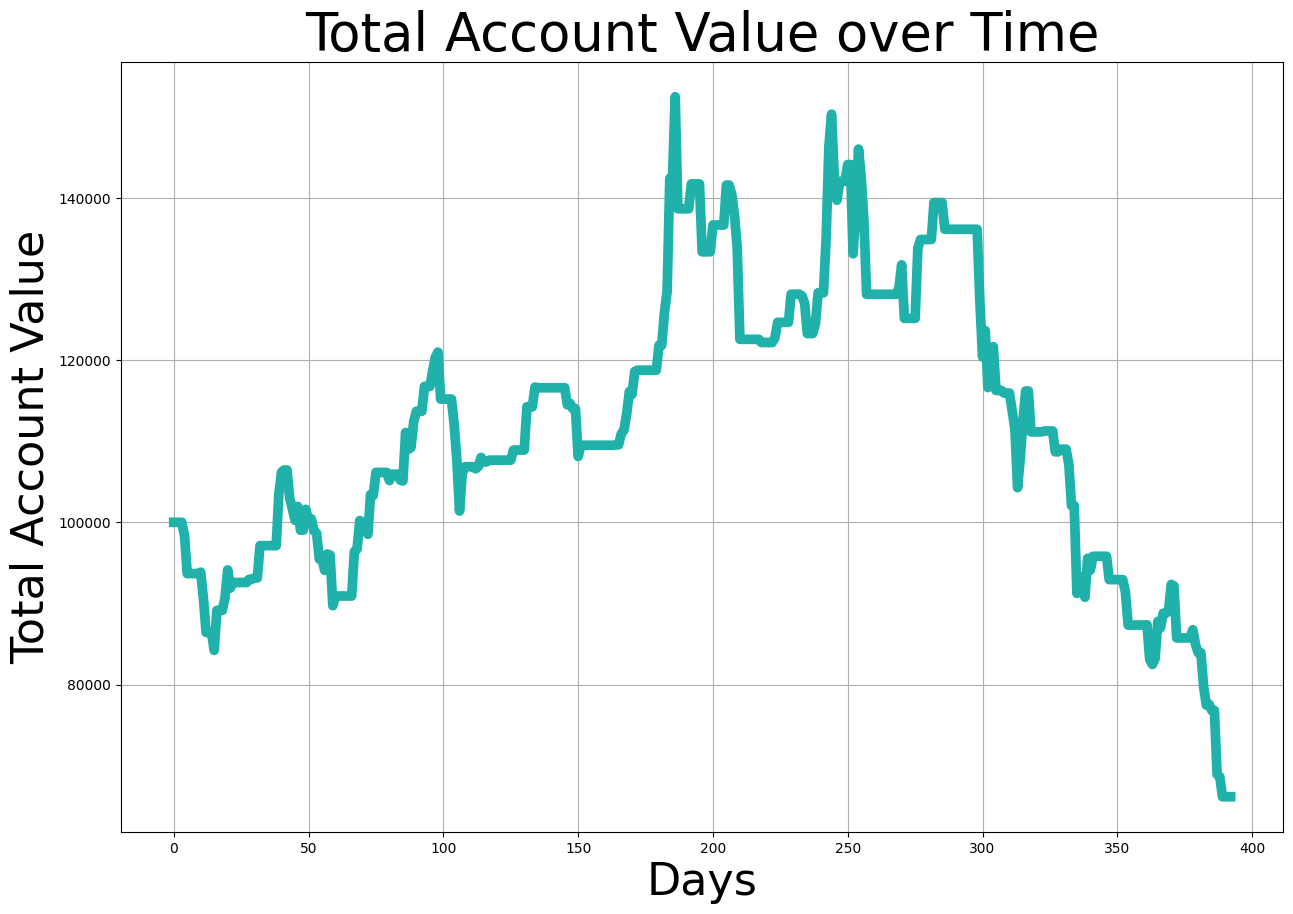

In [82]:
env.render()

Test Episode: 1, Total Reward: 205.27869066435989, Account Value: 153893.99360000002
Test Episode: 2, Total Reward: 205.27869066435989, Account Value: 153893.99360000002
Test Episode: 3, Total Reward: 205.27869066435989, Account Value: 153893.99360000002
Test Episode: 4, Total Reward: 205.27869066435989, Account Value: 153893.99360000002
Test Episode: 5, Total Reward: 205.27869066435989, Account Value: 153893.99360000002
Test Episode: 6, Total Reward: 205.27869066435989, Account Value: 153893.99360000002
Test Episode: 7, Total Reward: 205.27869066435989, Account Value: 153893.99360000002
Test Episode: 8, Total Reward: 205.27869066435989, Account Value: 153893.99360000002
Test Episode: 9, Total Reward: 205.27869066435989, Account Value: 153893.99360000002
Test Episode: 10, Total Reward: 205.27869066435989, Account Value: 153893.99360000002


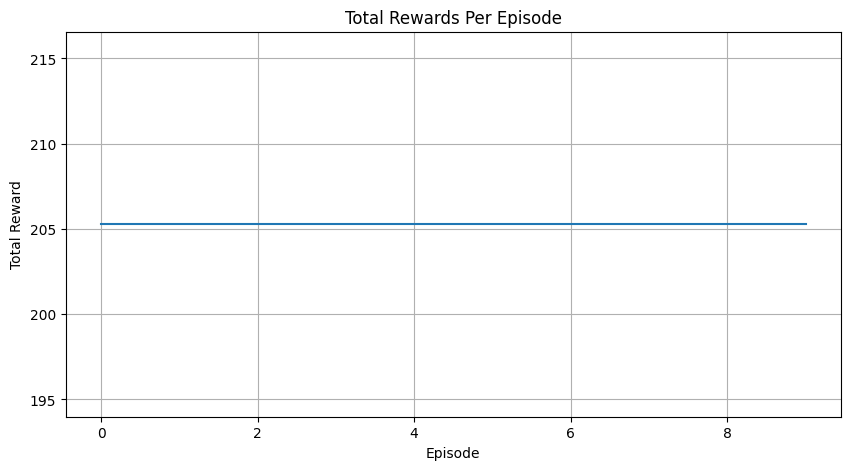

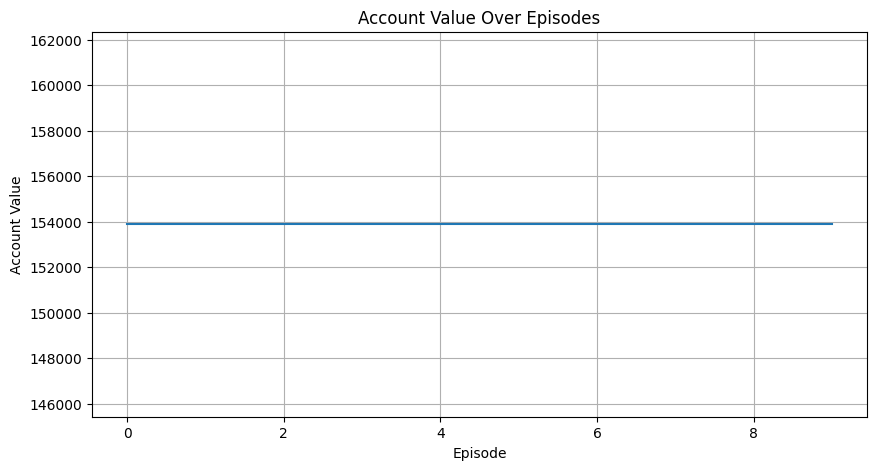

In [122]:
import torch
import matplotlib.pyplot as plt

def one_hot_encode(state, state_dimension):
    one_hot_state = torch.zeros(state_dimension)
    one_hot_state[state] = 1
    return one_hot_state

def test_actor_critic_agent(env, actor, num_episodes=10):
    """Test the trained actor for a given number of episodes and visualize the results."""
    total_rewards = []
    account_values = []

    for episode in range(num_episodes):
        state = env.reset()
        state = one_hot_encode(state, env.observation_space.n)
        done = False
        total_reward = 0

        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                action_probs = actor(state_tensor)
                action = torch.argmax(action_probs).item()

            next_state, reward, terminated, truncated, _ = env.step(action)
            next_state = one_hot_encode(next_state, env.observation_space.n)
            state = next_state
            total_reward += reward
            done = terminated or truncated

        total_rewards.append(total_reward)
        account_values.append(env.total_account_value)

        print(f"Test Episode: {episode + 1}, Total Reward: {total_reward}, Account Value: {env.total_account_value}")


    plt.figure(figsize=(10, 5))
    plt.plot(total_rewards)
    plt.title('Total Rewards Per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True)
    plt.show()


    plt.figure(figsize=(10, 5))
    plt.plot(account_values)
    plt.title('Account Value Over Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Account Value')
    plt.grid(True)
    plt.show()

    return total_rewards, account_values

if __name__ == '__main__':
    file_path = './NVDA.csv'
    env = StockTradingEnvironment(file_path=file_path, number_of_days_to_consider=10, train=False)
    input_dim = env.observation_space.n
    output_dim = env.action_space.n

    actor = Actor(input_dim, output_dim)



    test_actor_critic_agent(env, actor, num_episodes=10)

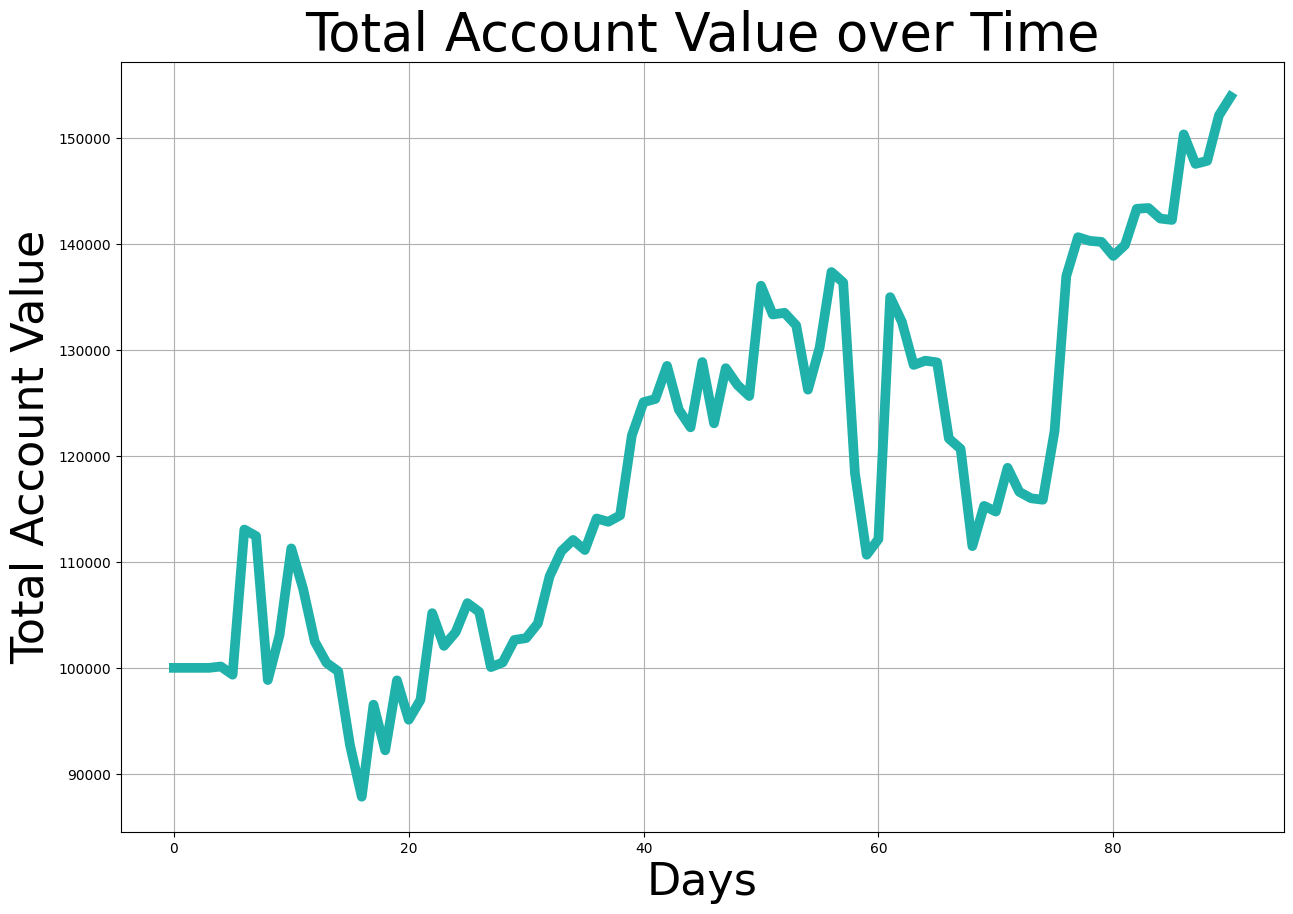

In [123]:
env.render()